In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
sys.path.append("../scripts")

from scripts.phase_detect import optimize_breakpoint
from scripts.denoising_models import (
    polyfit_model,
    polyfit_model_2,
    calibrate_signal,
    calibrate_signal_with_prior,
    calibrate_train,
    wavelet_smoothing,
    model_runner,
)
import scripts.metrics as metrics
from file_io import read_files
from preprocess import subtract_background, spatial_integration, bin_frequencies
from phase_detect import detector_runner, phase_detector, detect_best_breakpoint
from plotting_scripts import (
    plot_time_series_analysis,
    plot_relationships,
    plot_score_vs_constant,
)
from spectrum_calc import calculate_spectrum, ratio_from_timeseries
from metrics import simple_score, score
from generate_lc import idealized_light_curve, generate_ideal_wc

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
gt_df = pd.read_csv("../data/raw/train_labels.csv")
target_star_list = gt_df.planet_id

In [ ]:
# Prediction sequence
# Use the kaggle script generated airs files to calibrate


selected_targets = target_star_list
kaggle_airs = np.load("../data/processed/kaggle_sub_processed/airs_v4.npy")


def prediction_logic(target_list, gt_df=gt_df):

    # read files
    airs_selected = []
    fgs_selected = []
    gt_selected = []

    for target in target_list:
        _, fgs, gt = read_files(target, gt_df)
        # airs_selected.append(airs)
        fgs_selected.append(fgs)
        gt_selected.append(gt)

    airs_selected = kaggle_airs
    fgs_selected = np.vstack(fgs_selected)
    gt_selected = np.vstack(gt_selected)
    print("file read")

    # PREPROCESS
    # 1. subtracting the estimated background signal;
    airs_selected = subtract_background(airs_selected)
    # 2. integrate spatially across the center of the detector. Output shape of observations * t * freq
    airs_selected = spatial_integration(airs_selected)

    lc_phases, wc_phases = detector_runner(airs_selected, optimize_breakpoint)

    lc_phases = np.tile(
        wc_phases[:, np.newaxis, :], (1, 282, 1)
    )  # we will use wc_phases for both lc and wc for the time being, due to resolution limits

    # Frequency Binning:
    binned_airs_selected = bin_frequencies(airs_selected, 10)
    # plt.plot(binned_airs_selected[0].sum(axis=1))

    fitted_lc, fitted_wc = model_runner(
        binned_airs_selected, lc_phases, wc_phases, calibrate_signal
    )  # added median smoothing to the model runner

    lc_ratio, wc_ratio = calculate_spectrum(fitted_lc, fitted_wc, lc_phases, wc_phases)

    return (
        airs_selected,
        lc_phases,
        wc_phases,
        fitted_lc,
        fitted_wc,
        gt_selected,
        lc_ratio,
        wc_ratio,
    )
    print(airs_selected.shape)


def run_in_batches(data, batch_size=1000):
    # Initialize a list to collect outputs
    airs_selected = []
    lc_phases = []
    wc_phases = []
    fitted_lc = []
    fitted_wc = []
    gt_selected = []
    lc_ratio = []
    wc_ratio = []

    # Loop over data in specified batch sizes
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))  # Ensure we don't go out of bounds
        batch = data[start:end]

        # Run your prediction function on the current batch
        (
            airs_selected_1,
            lc_phases_1,
            wc_phases_1,
            fitted_lc_1,
            fitted_wc_1,
            gt_selected_1,
            lc_ratio_1,
            wc_ratio_1,
        ) = prediction_logic(batch)

        # Append the output to the list
        airs_selected.append(airs_selected_1)
        lc_phases.append(lc_phases_1)
        wc_phases.append(wc_phases_1)
        fitted_lc.append(fitted_lc_1)
        fitted_wc.append(fitted_wc_1)
        gt_selected.append(gt_selected_1)
        lc_ratio.append(lc_ratio_1)
        wc_ratio.append(wc_ratio_1)

    # Stack all outputs vertically into a single array
    airs_selected = np.vstack(airs_selected)
    lc_phases = np.vstack(lc_phases)
    wc_phases = np.vstack(wc_phases)
    fitted_lc = np.vstack(fitted_lc)
    fitted_wc = np.vstack(fitted_wc)
    gt_selected = np.vstack(gt_selected)
    lc_ratio = np.vstack(lc_ratio)
    wc_ratio = np.vstack(wc_ratio)
    return (
        airs_selected,
        lc_phases,
        wc_phases,
        fitted_lc,
        fitted_wc,
        gt_selected,
        lc_ratio,
        wc_ratio,
    )


(
    airs_selected,
    lc_phases,
    wc_phases,
    fitted_lc,
    fitted_wc,
    gt_selected,
    lc_ratio,
    wc_ratio,
) = run_in_batches(selected_targets)

file read
(673, 187, 282)


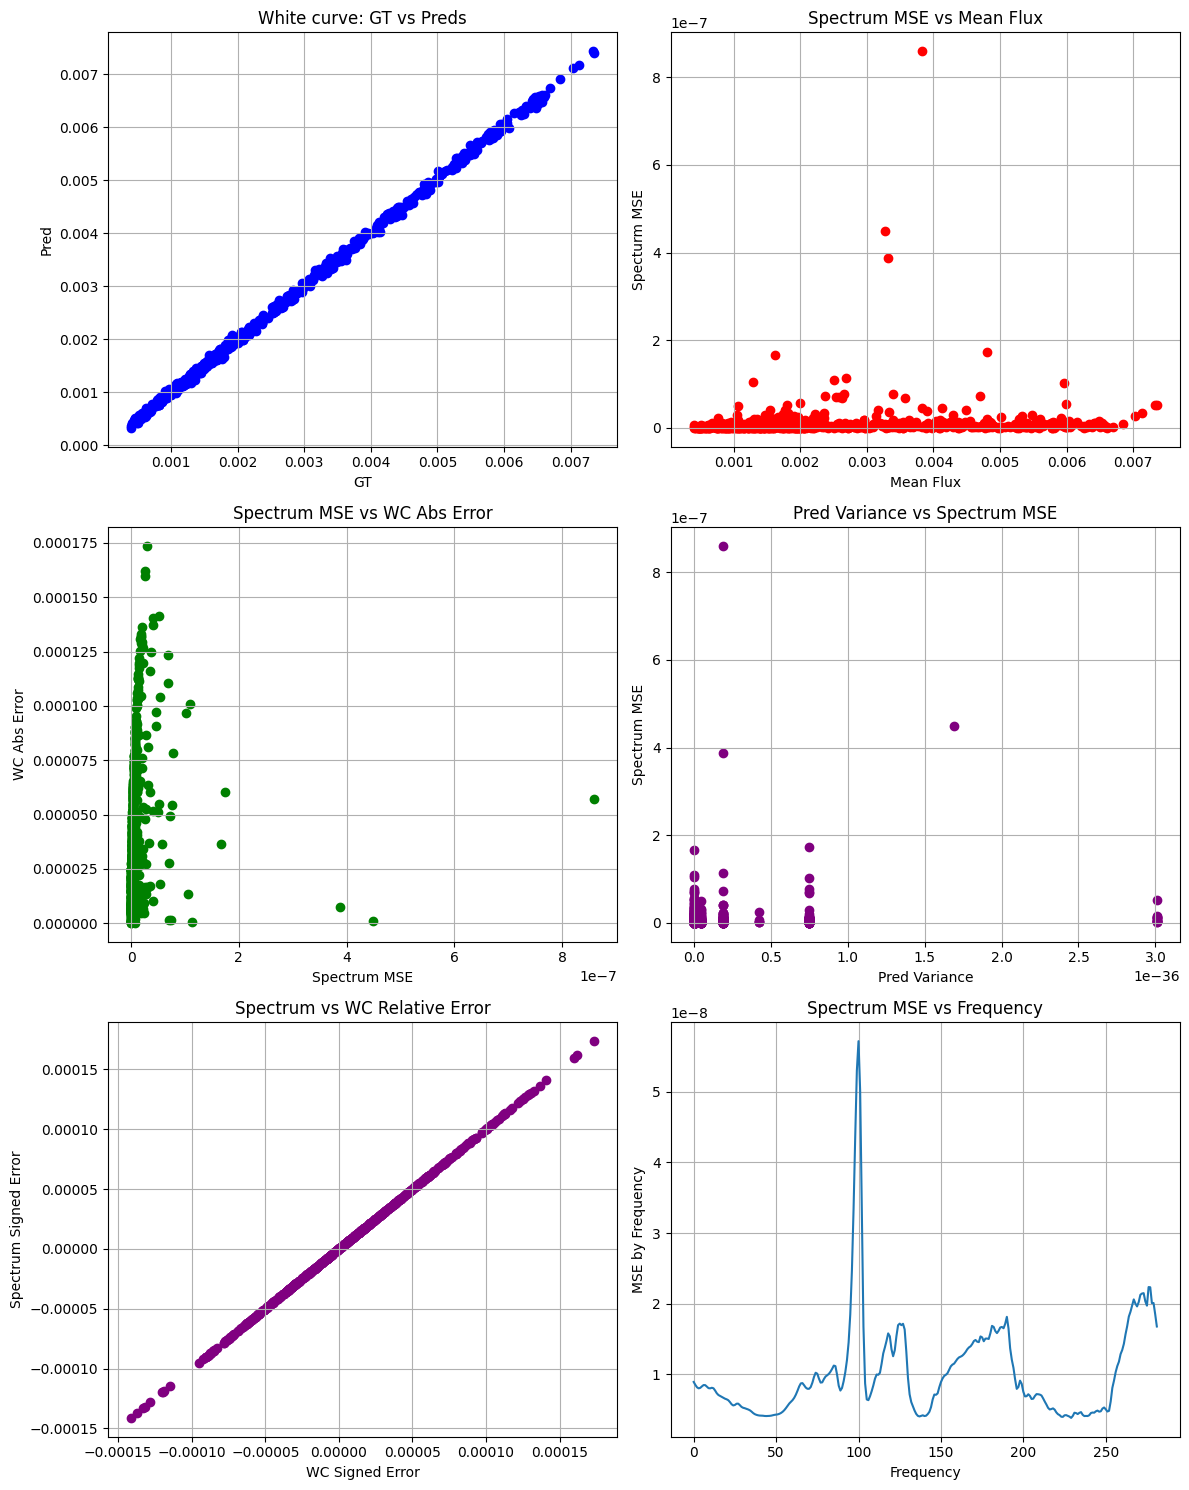

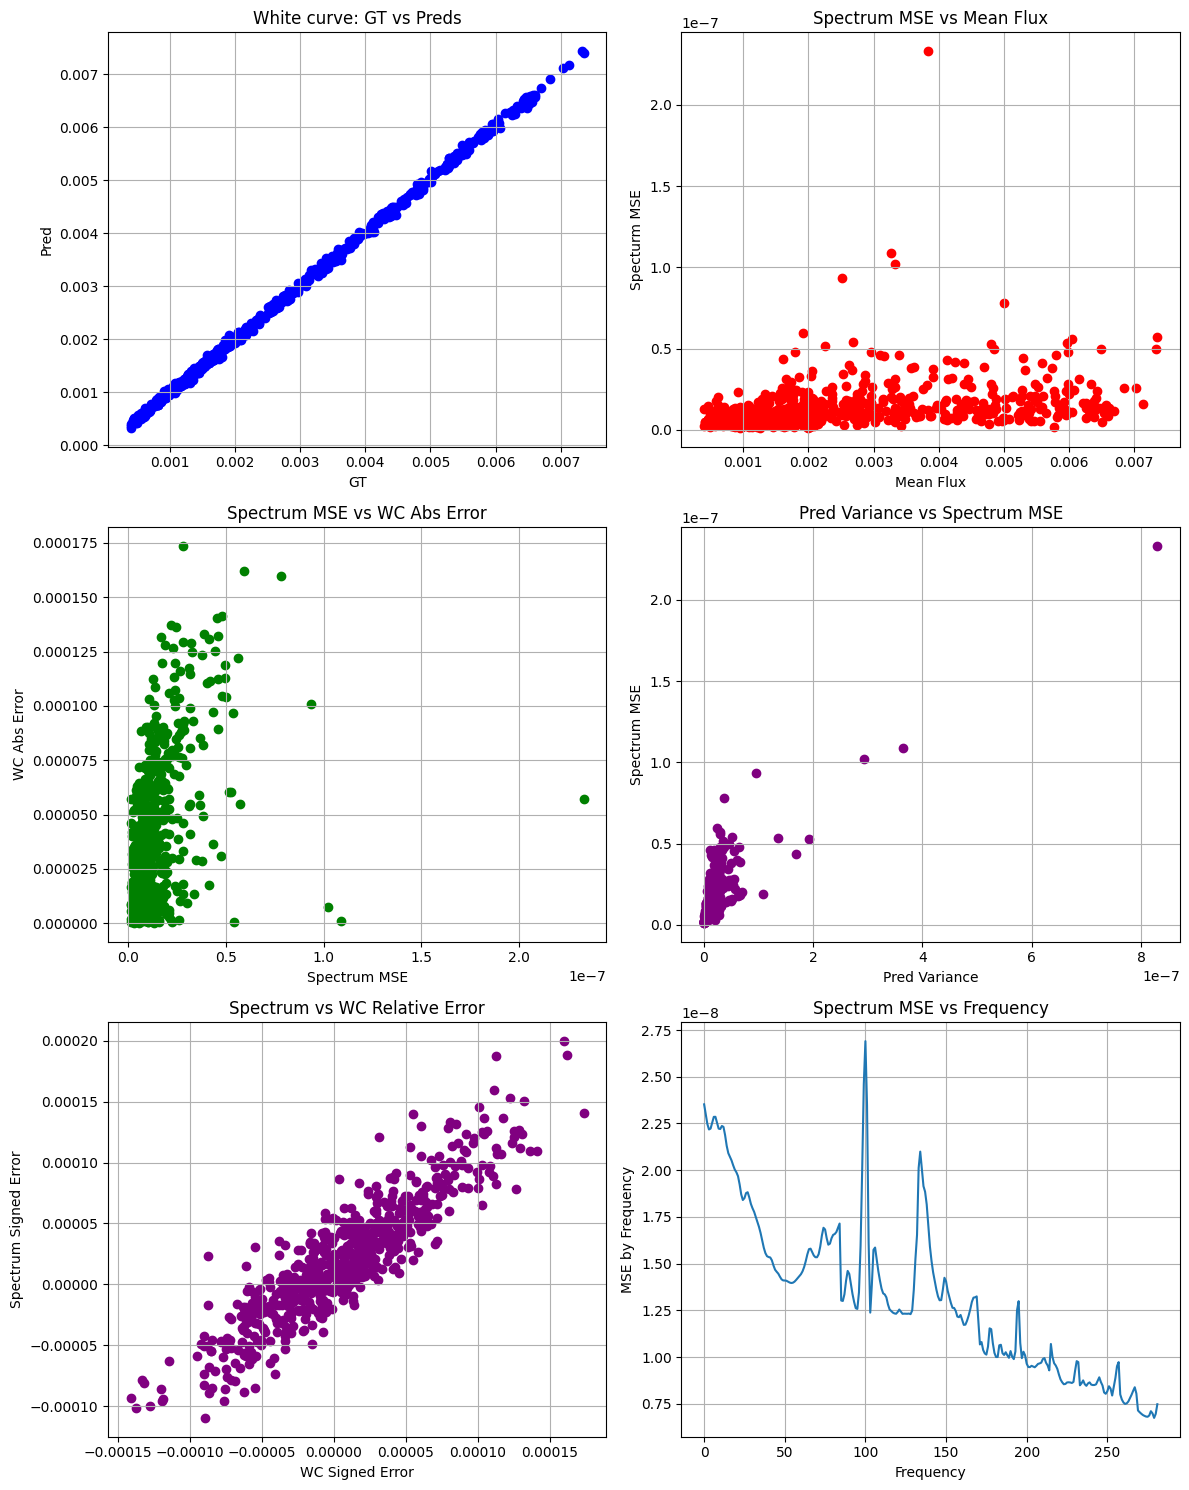

In [43]:
plot_relationships(wc_ratio, wc_ratio[:, 0], gt_selected[:, :-2])
plot_relationships(lc_ratio, wc_ratio[:, 0], gt_selected[:, :-2])

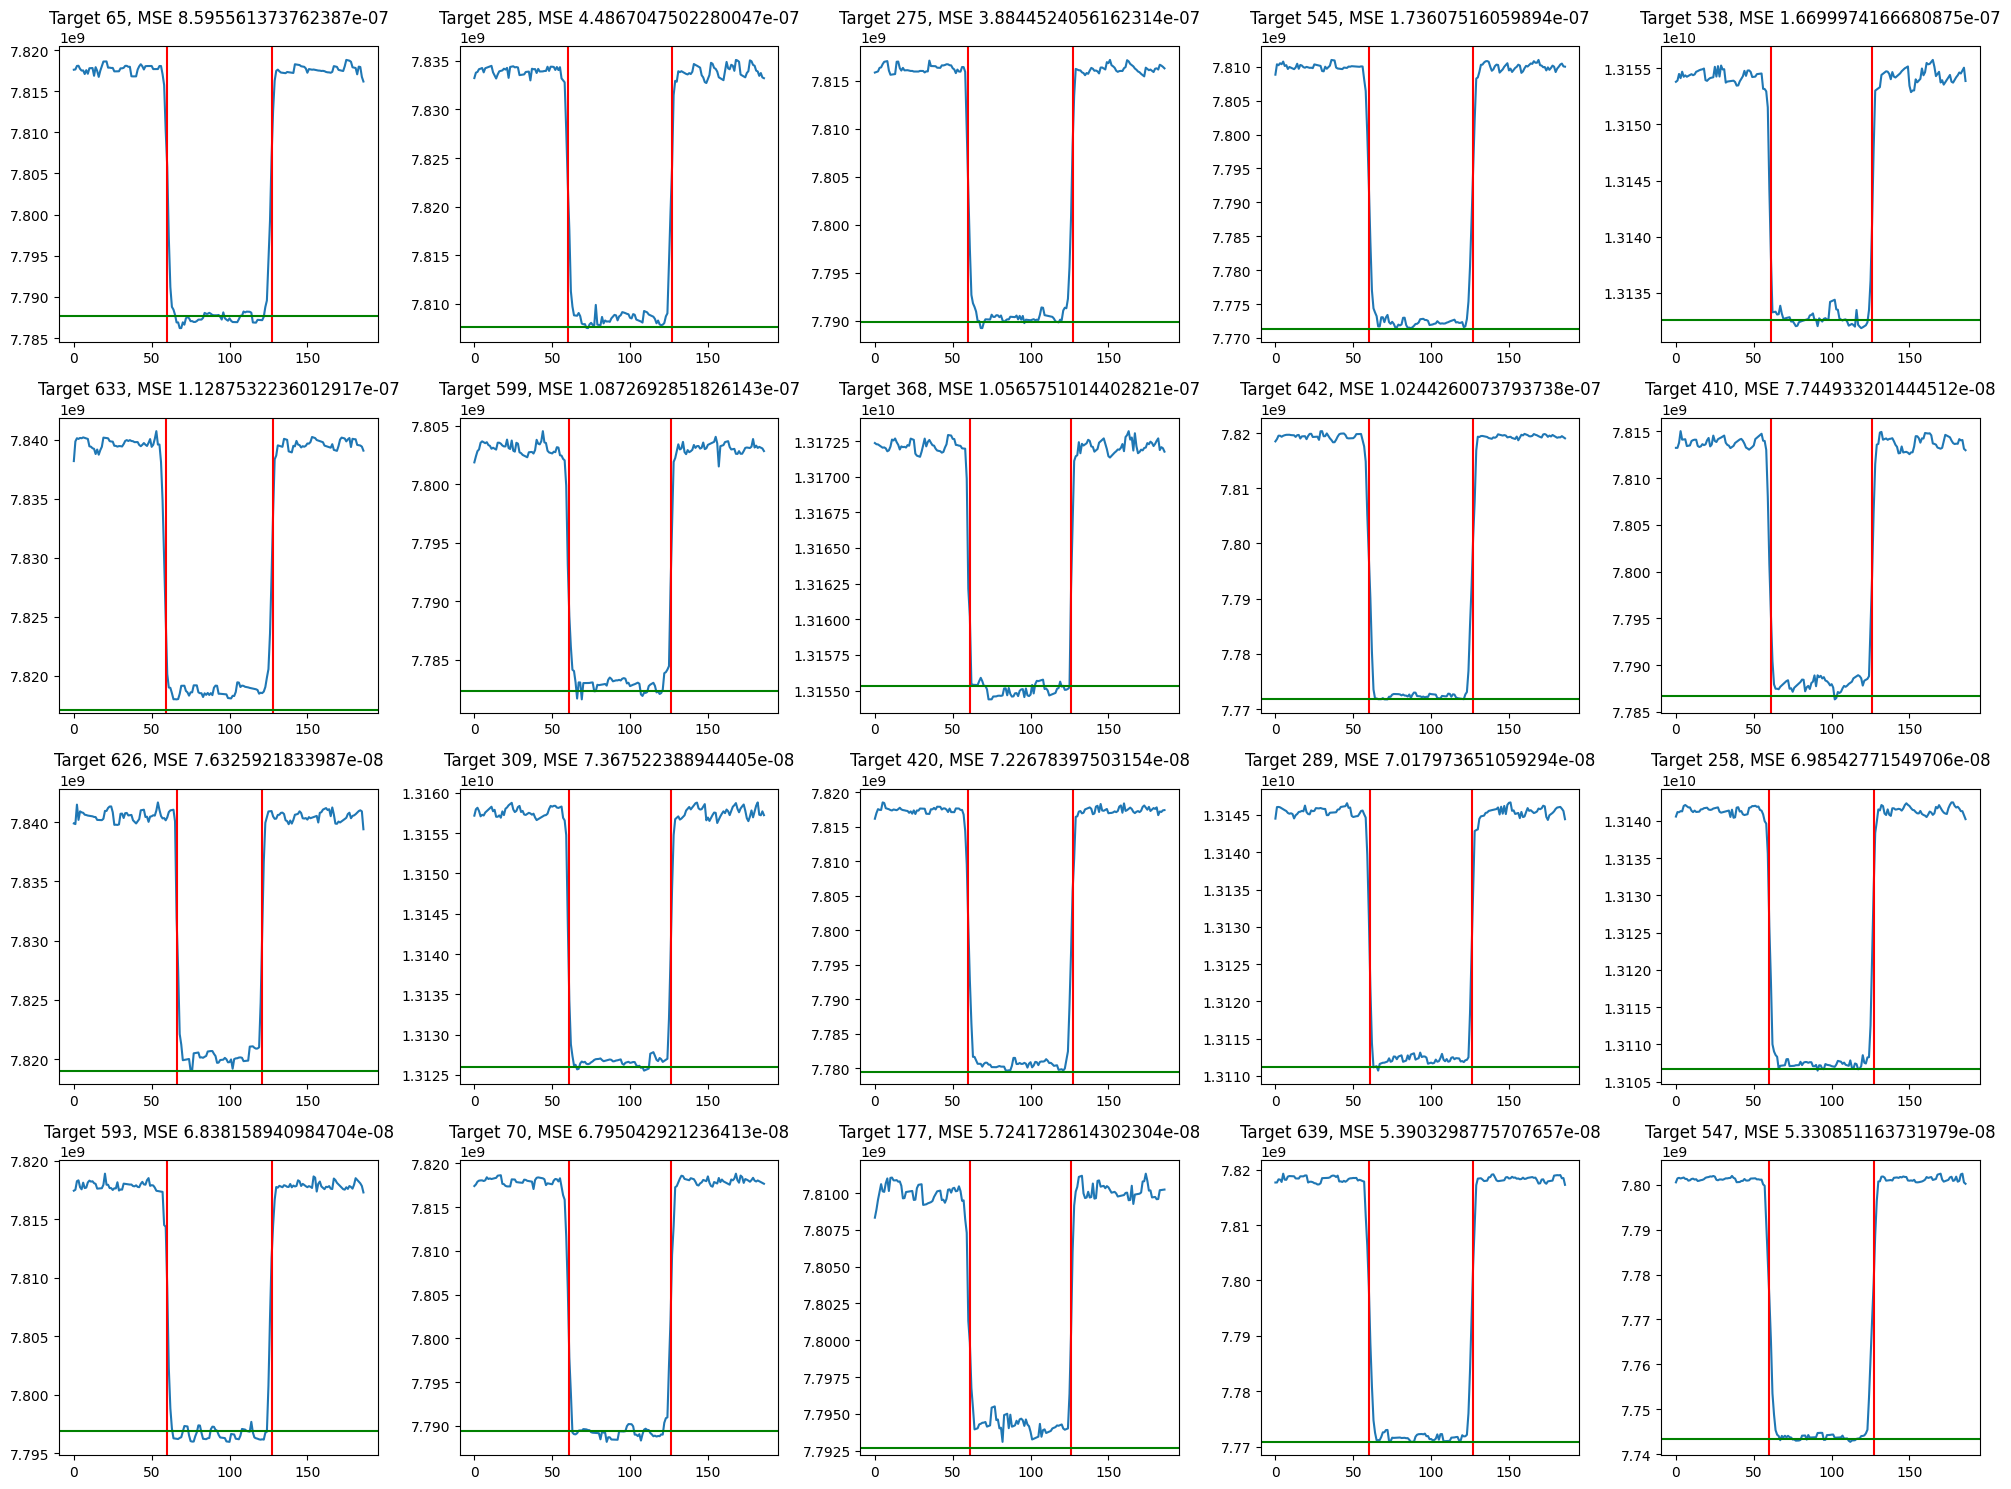

In [ ]:
# find the worst performing targets

avg_mse = (((wc_ratio - gt_selected[:, :-2]) ** 2)).mean(axis=1)

worst_indices = np.argsort(avg_mse)[::-1]

fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()

for ax, i in zip(axes, worst_indices[:20]):
    ax.plot(fitted_wc[i])
    ax.axvline(wc_phases[i][0], color="red")
    ax.axvline(wc_phases[i][1], color="red")
    ax.axhline((1 - gt_selected[i, :-2].mean()) * fitted_wc[i][0], color="green")
    ax.set_title(f"Target {i}, MSE {avg_mse[i]}")
plt.tight_layout()
plt.show()

Below section is for prediction generation.. boring...

In [107]:
combined_ratio

array([[0.00113298, 0.00113298, 0.00113298, ..., 0.00114199, 0.00114199,
        0.00114199],
       [0.00191405, 0.00191405, 0.00191405, ..., 0.00177654, 0.00177654,
        0.00177654],
       [0.00274879, 0.00274879, 0.00274879, ..., 0.0029037 , 0.0029037 ,
        0.0029037 ],
       ...,
       [0.00660349, 0.00660349, 0.00660349, ..., 0.00672133, 0.00672133,
        0.00672133],
       [0.0057458 , 0.0057458 , 0.0057458 , ..., 0.00567084, 0.00567084,
        0.00567084],
       [0.00151816, 0.00151816, 0.00151816, ..., 0.00155862, 0.00155862,
        0.00155862]])

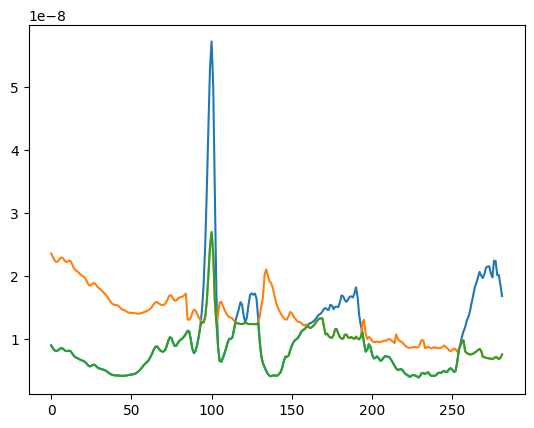

In [48]:
wc_error_array = ((wc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0)
lc_error_array = ((lc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0)
mask = wc_error_array > lc_error_array

combined_array = wc_error_array.copy()
combined_array[mask] = lc_error_array[mask]

combined_ratio = wc_ratio.copy()
combined_ratio[:, mask] = lc_ratio[:, mask]

plt.plot(((wc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
plt.plot(((lc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
plt.plot(((combined_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
# plt.plot(combined_array)

In [49]:
gt_df = pd.read_csv("../data/raw/train_labels.csv")
sample_sub = pd.read_csv("../data/raw/sample_submission.csv")

In [50]:
# Find the best scaling value for sigma
best_score = 0
best_scale = 0
naive_mean = np.mean(gt_df.values[:, 1:])
naive_sigma = np.std(gt_df.values[:, 1:])
best_sigmas = None

for i in np.arange(1, 3, 0.01):
    preds = combined_ratio[:, ::-1].copy()
    # preds = lc_ratio[:,::-1].copy()

    constant_value = np.full((preds.shape[0], 1), preds.mean().mean())

    sigmas = np.vstack(
        [np.std((combined_ratio[:, ::-1] - gt_df.iloc[:, 2:].values), axis=0) * i]
        * lc_ratio.shape[0]
    )

    preds = np.hstack((constant_value, preds))
    constant_value = np.full((sigmas.shape[0], 1), sigmas.mean())
    sigmas = np.hstack((constant_value, sigmas))

    sub_frame = pd.DataFrame(
        np.concatenate([preds, sigmas], axis=1), columns=sample_sub.columns[1:]
    )

    curren_score = score(
        gt_df.iloc[:, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5
    )
    if curren_score > best_score:
        best_score = curren_score
        best_scale = i
        best_sigmas = sigmas

print(f"Best scale at {best_scale}, best score at {best_score}")

Best scale at 1.6000000000000005, best score at 0.45473341573197706


In [108]:
combined_ratio

array([[0.00113298, 0.00113298, 0.00113298, ..., 0.00114199, 0.00114199,
        0.00114199],
       [0.00191405, 0.00191405, 0.00191405, ..., 0.00177654, 0.00177654,
        0.00177654],
       [0.00274879, 0.00274879, 0.00274879, ..., 0.0029037 , 0.0029037 ,
        0.0029037 ],
       ...,
       [0.00660349, 0.00660349, 0.00660349, ..., 0.00672133, 0.00672133,
        0.00672133],
       [0.0057458 , 0.0057458 , 0.0057458 , ..., 0.00567084, 0.00567084,
        0.00567084],
       [0.00151816, 0.00151816, 0.00151816, ..., 0.00155862, 0.00155862,
        0.00155862]])

In [70]:
np.save("../outputs/results/basic_fit/mask.npy", mask)

In [51]:
np.save("../outputs/results/basic_fit/sigmas_single.npy", best_sigmas[0])
np.save("../outputs/results/basic_fit/lc_ratio.npy", lc_ratio)
np.save("../outputs/results/basic_fit/wc_ratio.npy", wc_ratio)
np.save("../outputs/results/basic_fit/wc_curves.npy", fitted_wc)
np.save("../outputs/results/basic_fit/lc_curves.npy", fitted_lc)

In [ ]:
np.save("../outputs/results/basic_fit/wc_phases.npy", wc_phases)

In [110]:
# How off can we be, before we get to zero score? At around 11% off

error_factor = 1
print(f"current avg sigma est. {best_sigmas.mean()}")

sub_frame = pd.DataFrame(
    np.concatenate([preds * error_factor, best_sigmas * 2], axis=1),
    columns=sample_sub.columns[1:],
)

print(
    f'current score {score(
        gt_df.iloc[:, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5
    )}'
)

current avg sigma est. 0.0001353309231618437
current score 0.39808546468832917


--------------- End of prediction calibration ----------------->